In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("/Users/marcsauer/PycharmProjects/Swim/src/")
from preprocessing import Preprocessing

In [20]:
testrun = 'run_1_3'
pre = Preprocessing(testrun)

In [21]:
# Load data
raw_accel = pre.load_data('accel-175130000657-20190404T145109Z.csv', name='raw_accel', header=None)
raw_gyro = pre.load_data('gyro-175130000657-20190404T145110Z.csv', name='raw_gyro', header=None)
raw_magn = pre.load_data('magn-175130000657-20190404T145109Z.csv', name='raw_magn', header=None)

In [22]:
# Create data frame with all sensor information
column_names = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Magn_X', 'Magn_Y', 'Magn_Z']
raw_data = pd.concat([raw_accel, raw_gyro, raw_magn], axis=1, sort=False)
raw_data.columns = column_names
raw_data.head(5)

,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Magn_X,Magn_Y,Magn_Z
0,-3.376393,0.145967,-9.557275,0.840000,-0.84,0.84,-71.700005,-62.850002,167.550003
1,-3.469717,0.045465,-9.554882,-1.680000,0.77,1.05,-72.900002,-62.700001,165.750000
2,-3.285463,-0.014357,-9.040407,2.730000,0.07,0.14,-71.850006,-61.050003,166.800003
3,-3.443395,-0.038287,-9.392164,-7.420000,-2.73,-0.56,-71.850006,-62.400002,168.450012
4,-3.677900,-0.074180,-10.614941,-26.809999,0.49,-5.39,-71.850006,-62.250004,168.000000


In [23]:
raw_data.shape

(4108, 9)

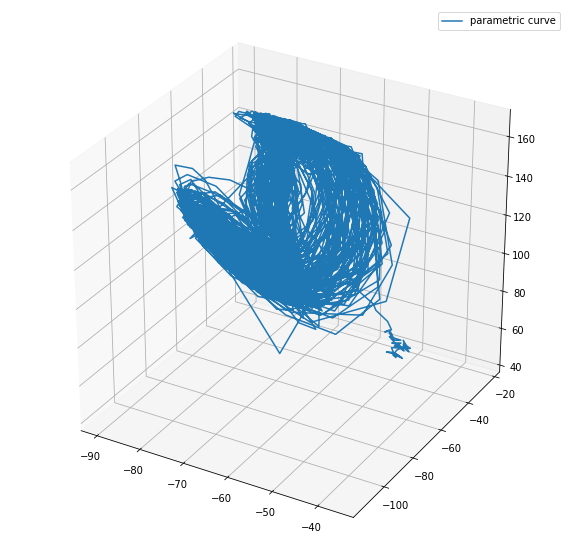

In [24]:
# Plot data (13 Hz)
fig = plt.figure(10, figsize= (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(raw_data['Magn_X'], raw_data['Magn_Y'], raw_data['Magn_Z'], label='parametric curve')
ax.legend()
plt.show()

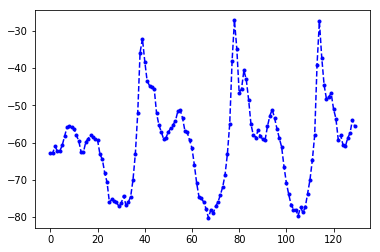

In [25]:
# plt.plot(raw_all[:60].index, raw_all[:60]['Magn_X'])
plt.plot(raw_data[:130].index, raw_data[:130]['Magn_Y'],'b.--')
# plt.plot(raw_all[:60].index, raw_all[:60]['Magn_Z'])

# plt.plot(raw_all[60:120].index, raw_all[60:120]['Magn_X'])
# plt.plot(raw_all[60:120].index, raw_all[60:120]['Magn_Y'])
# plt.plot(raw_all[60:120].index, raw_all[60:120]['Magn_Z'])
# 

plt.show()

In [26]:
# Define stroke cut
Magn_Y_max = raw_data['Magn_Y'].max()
Magn_Y_min = raw_data['Magn_Y'].min()
min_max_range = Magn_Y_max-Magn_Y_min
stroke_cut = Magn_Y_max-(min_max_range*.25)
print(stroke_cut)

-45.71250275


In [28]:
# Create data frame for every single stroke
def single_stroke(raw_data, testrun):
    # Define stroke cut
    Magn_Y_max = raw_data['Magn_Y'].max()
    Magn_Y_min = raw_data['Magn_Y'].min()
    min_max_range = Magn_Y_max-Magn_Y_min
    stroke_cut = Magn_Y_max-(min_max_range*.25)
    
    # Cut stroke
    single_stroke_end = []
    for i in range(0,len(raw_data['Magn_Y'])):
        if (raw_data['Magn_Y'][i] > stroke_cut) == True and (raw_data['Magn_Y'][i-1] < stroke_cut) == True:
            single_stroke_end.append(i)
    
    # Create list of data frames
    single_stroke_end_mod = [-1] + single_stroke_end
    list_of_dfs = [raw_data.iloc[single_stroke_end_mod[n]+1:single_stroke_end_mod[n+1]+1] for n in range(len(single_stroke_end_mod)-1)]
    
    # Save single strokes to csv
    k = 1
    for i in range(0, len(list_of_dfs)):
        pd.DataFrame(list_of_dfs[i]).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_{}.csv'.format(testrun, k), index=False)
        k += 1

In [32]:
single_stroke(raw_data, testrun)
single_stroke_133 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_133.csv'.format(testrun))
single_stroke_2 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_2.csv'.format(testrun))

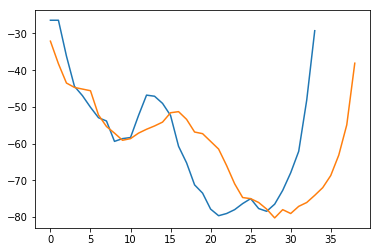

In [33]:
#plt.plot(single_stroke_99['Magn_Y'])
plt.plot(single_stroke_133['Magn_Y'])
plt.plot(single_stroke_2['Magn_Y'])
plt.show()